In [9]:
%matplotlib inline

# Fatigue Analysis in Basketball: Impact on Shooting Performance

### Research Question
**How does fatigue affect a player's performance and ability to shoot in-game?**

#### Hypothesis:
Fatigue significantly impacts shooting performance by reducing the height of the player's jump, which can cause their shots to fall short.

#### Key Metrics to Measure:
- **Jump Height**: A lower vertical jump could indicate fatigue.
- **Shot Success Rate**: Tracking whether the player misses more shots when fatigued.
- **Shot Distance and Accuracy**: Shots falling short could correlate with increased fatigue.
- **Time of Play**: Longer time on the court could decrease shooting performance.

---

## Loading Free Throw Data

This example uses the SPL Open Data repository to analyze free throw data. The goal is to extract jump heights and shot outcomes to determine the relationship between fatigue and performance.


In [2]:
import json
import numpy as np
import pickle 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load and parse free throw data
def load_data(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

# Extract features: jump height, ball possession, team jersey color
def extract_features(data, team_color):
    features = []
    fatigue_labels = []

    player_data = data.get('tracking', [])
    result = data.get('result', '')

    if not isinstance(player_data, list):
        return np.array(features), np.array(fatigue_labels)

    ball_possession = any(p.get('data', {}).get('ball') is not None for p in player_data)
    jump_heights = [p.get('data', {}).get('player', {}).get('L_ANKLE', [0, 0, 0])[2] for p in player_data]
    max_jump_height = max(jump_heights) if jump_heights else 0
    jersey_color = 1 if data.get('participant_id') == team_color else 0
    fatigue_level = infer_fatigue(result)

    features.append([max_jump_height, ball_possession, jersey_color])
    fatigue_labels.append(fatigue_level)

    return np.array(features), np.array(fatigue_labels)

# Infer fatigue from the result of a shot
def infer_fatigue(result):
    return 10 if result == 'missed' else 5

# Define the model and hyperparameter grid
def train_fatigue_model(features, fatigue_labels):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor())
    ])

    param_grid = {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 7]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5), scoring='neg_mean_squared_error')
    grid_search.fit(features, fatigue_labels)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best MSE: {-grid_search.best_score_}")

    return grid_search.best_estimator_

# Save the trained model to a .pkl file
def save_model(model, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {file_name}")

# Main processing
all_features = []
all_labels = []

for trial_number in range(1, 126):
    trial_id = str(trial_number).zfill(4)
    data_file = f'./data/P0001/BB_FT_P0001_T{trial_id}.json'

    data = load_data(data_file)

    features, labels = extract_features(data, 'P0001')

    if len(features) > 0 and len(labels) > 0:
        all_features.extend(features)
        all_labels.extend(labels)

all_features = np.array(all_features)
all_labels = np.array(all_labels)

if len(all_features) > 0 and len(all_labels) > 0:
    fatigue_model = train_fatigue_model(all_features, all_labels)
    save_model(fatigue_model, 'fatigue_model.pkl')
else:
    print("No valid data to train the model.")


Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
Best MSE: 5.719303332337492
Model saved to fatigue_model.pkl


## 3D Animation 

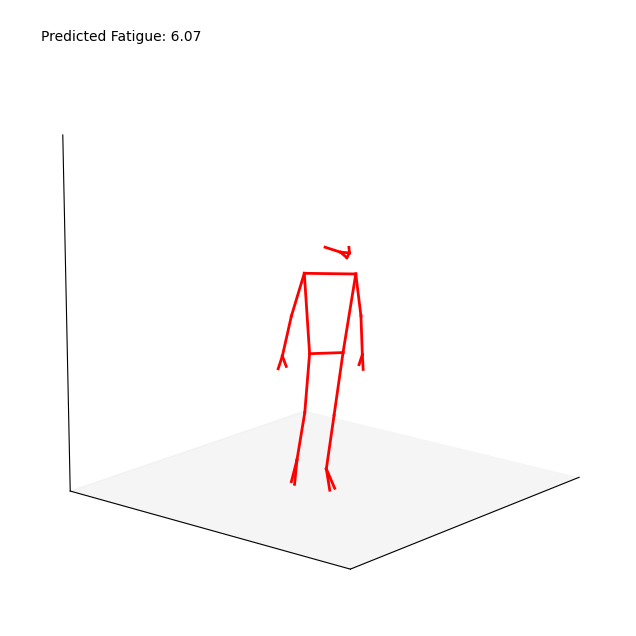

In [16]:
%matplotlib inline
import numpy as np
import json
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Ensure 3D plotting
import pickle
from IPython.display import HTML  # Only needed for notebook display

# Load the fatigue model
with open('fatigue_model.pkl', 'rb') as model_file:
    fatigue_model = pickle.load(model_file)

# Define the connections between joints
connections = [
    ("R_EYE", "L_EYE"),
    ("R_EYE", "NOSE"),
    ("L_EYE", "NOSE"),
    ("R_EYE", "R_EAR"),
    ("L_EYE", "L_EAR"),
    ("R_SHOULDER", "L_SHOULDER"),
    ("R_SHOULDER", "R_ELBOW"),
    ("L_SHOULDER", "L_ELBOW"),
    ("R_ELBOW", "R_WRIST"),
    ("L_ELBOW", "L_WRIST"),
    ("R_SHOULDER", "R_HIP"),
    ("L_SHOULDER", "L_HIP"),
    ("R_HIP", "L_HIP"),
    ("R_HIP", "R_KNEE"),
    ("L_HIP", "L_KNEE"),
    ("R_KNEE", "R_ANKLE"),
    ("L_KNEE", "L_ANKLE"),
    ("R_WRIST", "R_1STFINGER"),
    ("R_WRIST", "R_5THFINGER"),
    ("L_WRIST", "L_1STFINGER"),
    ("L_WRIST", "L_5THFINGER"),
    ("R_ANKLE", "R_1STTOE"),
    ("R_ANKLE", "R_5THTOE"),
    ("L_ANKLE", "L_1STTOE"),
    ("L_ANKLE", "L_5THTOE"),
]

# Function to animate the trial and visualize fatigue
def animate_trial_with_fatigue(
    path_to_json,
    connections=connections,
    xbuffer=4.0,
    ybuffer=4.0,
    zlim=8.0,
    elev=15.0,
    azim=40.0,
    player_color="red",
    player_lw=2,
    ball_color="#ee6730",
    ball_size=20.0,
    show_court=True,
    notebook_mode=True,  # Parameter to control Jupyter notebook behavior
):
    # Handle Jupyter notebook mode
    if notebook_mode:
        plt.rcParams['animation.html'] = 'jshtml'  # Set animation display to inline JS
    
    # Load player data from JSON
    with open(path_to_json, "r") as f:
        data = json.load(f)

    player_joint_dict = {}
    ball_data_array = []

    N_frames = len(data["tracking"])

    for frame_data in data["tracking"]:
        for joint in frame_data["data"]["player"]:
            if joint not in player_joint_dict:
                player_joint_dict[joint] = []
            player_joint_dict[joint].append(frame_data["data"]["player"][joint])
        ball_data_array.append(frame_data["data"]["ball"])

    for joint in player_joint_dict:
        player_joint_dict[joint] = np.array(player_joint_dict[joint])
    ball_data_array = np.array(ball_data_array)

    # Setting up the animation plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.set_zlim([0, zlim])
    ax.set_box_aspect([1, 1, 1])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.view_init(elev=elev, azim=azim)

    # Prepare the lines to be updated
    lines = {
        connection: ax.plot([], [], [], c=player_color, lw=player_lw)[0]
        for connection in connections
    }
    (ball,) = ax.plot([], [], [], "o", markersize=ball_size, c=ball_color)

    # Adding fatigue display
    fatigue_text = ax.text2D(0.05, 0.95, "", transform=ax.transAxes)

    def update(frame):
        rh_xy = player_joint_dict["R_HIP"][frame][:2]
        lh_xy = player_joint_dict["L_HIP"][frame][:2]
        mh_xy = (rh_xy + lh_xy) / 2
        ax.set_xlim([mh_xy[0] - xbuffer, mh_xy[0] + xbuffer])
        ax.set_ylim([mh_xy[1] - ybuffer, mh_xy[1] + ybuffer])

        for connection in connections:
            part1, part2 = connection
            x = [
                player_joint_dict[part1][frame, 0],
                player_joint_dict[part2][frame, 0],
            ]
            y = [
                player_joint_dict[part1][frame, 1],
                player_joint_dict[part2][frame, 1],
            ]
            z = [
                player_joint_dict[part1][frame, 2],
                player_joint_dict[part2][frame, 2],
            ]
            lines[connection].set_data(x, y)
            lines[connection].set_3d_properties(z)

        # Update ball data
        x = ball_data_array[frame, 0]
        y = ball_data_array[frame, 1]
        z = ball_data_array[frame, 2]
        ball.set_data([x], [y])
        ball.set_3d_properties([z])

        # Extract the jump height (z coordinate of L_ANKLE) and predict fatigue
        jump_height = player_joint_dict["L_ANKLE"][frame, 2]
        ball_possession = not np.isnan(ball_data_array[frame]).any()
        features = np.array([[jump_height, ball_possession, 1]])  # Assuming team color = 1
        predicted_fatigue = fatigue_model.predict(features)[0]

        # Display predicted fatigue and shot efficiency
        fatigue_text.set_text(f"Predicted Fatigue: {predicted_fatigue:.2f}")

    anim = FuncAnimation(fig, update, frames=N_frames, interval=1000 / 30)

    # Handle display in notebook or external window
    if notebook_mode:
        return HTML(anim.to_jshtml())  # Return HTML animation in notebook mode
    else:
        plt.show()  # Show animation in a window outside notebook

    return anim

for trial_number in range(1, 126):
    trial_id = str(trial_number).zfill(4)
    data_file = f'./data/P0001/BB_FT_P0001_T{trial_id}.json'

# Example usage in a Jupyter notebook
animate_trial_with_fatigue(data_file, notebook_mode=True)


## Predicting Fatigue Using Computer Vision

We can develop a real-time fatigue prediction model using computer vision to track a player's jump height and performance during shooting.

### Example: Real-time Pose Detection Using MediaPipe

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pickle  # To load pre-trained fatigue model

# Initialize MediaPipe pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Load the pre-trained fatigue model (RandomForest in this example)
with open('fatigue_model.pkl', 'rb') as f:
    fatigue_model = pickle.load(f)

# Function to convert an RGB color to its HSV range with tolerance
def rgb_to_hsv_range(rgb_color, tolerance=40):
    rgb_color = np.uint8([[rgb_color]])  # Convert the RGB value to the proper format
    hsv_color = cv2.cvtColor(rgb_color, cv2.COLOR_RGB2HSV)[0][0]  # Convert to HSV
    
    lower_bound = np.array([hsv_color[0] - tolerance, 100, 100])  # Adjust tolerance for hue
    upper_bound = np.array([hsv_color[0] + tolerance, 255, 255])  # Saturation and value at max
    
    return lower_bound, upper_bound

# Function to detect team jersey color
def detect_team_jersey_color(frame, lower_hsv, upper_hsv):
    """Detect if the player is wearing the team jersey by color."""
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_frame, lower_hsv, upper_hsv)
    team_color_present = np.any(mask)  # Boolean for team color detection
    return team_color_present

# Function to detect ball
def detect_ball(frame):
    """Basic detection of the ball using contour detection (can be enhanced)."""
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)
    _, thresh = cv2.threshold(blurred_frame, 60, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Adjust area threshold for ball size
            return True  # Ball detected
    
    return False

# Capture video from default camera
cap = cv2.VideoCapture(0)

# Example: Define RGB color for team jersey (e.g., red team)
team_rgb_color = [255, 0, 0]  # Replace with any RGB value
lower_hsv, upper_hsv = rgb_to_hsv_range(team_rgb_color)

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Convert the frame to RGB for MediaPipe processing
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Pose detection with MediaPipe
    result = pose.process(img_rgb)
    
    # Detect team jersey color
    is_team_member = detect_team_jersey_color(frame, lower_hsv, upper_hsv)
    
    # Detect if player is holding the ball
    ball_detected = detect_ball(frame)
    
    if result.pose_landmarks:
        # Draw landmarks
        mp.solutions.drawing_utils.draw_landmarks(frame, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        # Extract keypoints for jump height calculation
        ankle_right = result.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE]
        knee_right = result.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE]
        
        # Calculate vertical jump height in meters (approximation)
        jump_height = abs(ankle_right.z - knee_right.z)  # Z-coordinates give depth (approximating vertical height)
        
        # Display jump height on the frame
        cv2.putText(frame, f"Jump Height: {jump_height:.2f}m", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Predict fatigue based on features: [jump_height, ball_possession, is_team_member]
        fatigue_input = np.array([[jump_height, ball_detected, is_team_member]])
        predicted_fatigue = fatigue_model.predict(fatigue_input)[0]
        
        # Display the predicted fatigue level
        cv2.putText(frame, f"Predicted Fatigue: {predicted_fatigue:.2f}", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Show the processed video frame
    cv2.imshow("Fatigue Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

## Graph Correlation between shot outcome and fatigue level

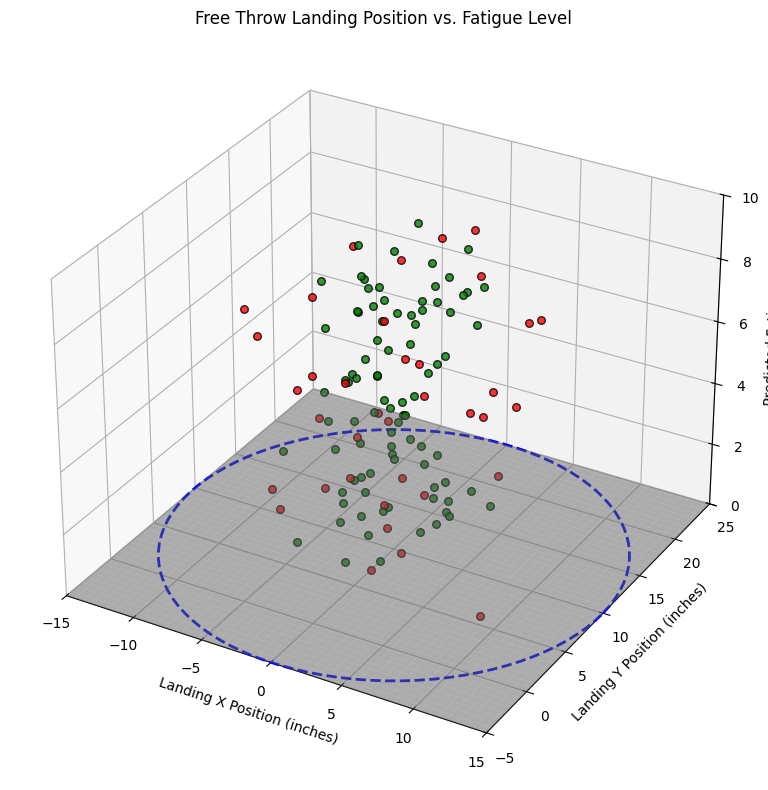

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import json

TRIALS = 126
CIRCLE_RADIUS = 15
FATIGUE_LIMIT = 10

def load_trial_data(trial_number):
    """Load trial data from JSON file"""
    trial_id = str(trial_number).zfill(4)
    try:
        with open(f'./data/P0001/BB_FT_P0001_T{trial_id}.json') as json_file:
            return json.load(json_file)
    except FileNotFoundError:
        return None
    except Exception as e:
        print(f"Error loading trial {trial_number}: {e}")
        return None

def plot_correlation(data):
    """Plot correlation between fatigue level and shot outcome"""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for trial_data in data:
        if trial_data is None:
            continue

        color = 'green' if trial_data['result'] =='made' else'red'
        landing_x = trial_data['landing_x']
        landing_y = trial_data['landing_y']
        predicted_fatigue = trial_data.get('predicted_fatigue', np.random.uniform(0, FATIGUE_LIMIT))

        ax.scatter(landing_x, landing_y, predicted_fatigue, color=color, alpha=0.8, edgecolors='black', s=30)

    # Create the ground plane (z = 0) for the x-y plane using plot_surface
    X, Y = np.meshgrid(np.linspace(-15, 15, 100), np.linspace(-5, 25, 100))
    Z = np.zeros_like(X)
    ax.plot_surface(X, Y, Z, color='gray', alpha=0.5)  # ground plane

    # Adding a circular boundary to the x-y plane
    theta = np.linspace(0, 2 * np.pi, 100)
    x_circle = CIRCLE_RADIUS * np.cos(theta)
    y_circle = CIRCLE_RADIUS * np.sin(theta) + 10 
    z_circle = np.ones_like(theta) * 0  # Move the circle up by setting z to a constant value

    ax.plot(x_circle, y_circle, z_circle, color='blue', linestyle='--', linewidth=2)

    ax.set_xlim([-15, 15])
    ax.set_ylim([-5, 25])
    ax.set_zlim([0, FATIGUE_LIMIT])

    ax.set_xlabel('Landing X Position (inches)')
    ax.set_ylabel('Landing Y Position (inches)')
    ax.set_zlabel('Predicted Fatigue')
    ax.set_title('Free Throw Landing Position vs. Fatigue Level')

    plt.tight_layout()
    plt.show()

def main():
    data = [load_trial_data(i) for i in range(1, TRIALS + 1)]
    plot_correlation(data)

if __name__ == "__main__":
    main()
		

### Conclusion
This analysis helps determine how fatigue impacts a player's ability to shoot. By combining jump height measurements and shot outcomes, we can create a model that predicts fatigue in real-time.